In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('tdrstyle.mplstyle')
%matplotlib inline

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

from rootpy.io import root_open

def load_minbias_batch(j):
  global infile_r
  pufiles = ['root://cmsxrootd-site.fnal.gov//store/group/l1upgrades/L1MuonTrigger/P2_10_1_5/ntuple_SingleNeutrino_PU200/ParticleGuns/CRAB3/180719_210355/0000/ntuple_SingleNeutrino_PU200_%i.root' % (i+1) for i in xrange(63)]
  infile = pufiles[j]
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  return tree

Welcome to JupyROOT 6.10/09


In [2]:
jobs = [0,1,2,3,4,5]
nevents_per_job = 8000

# Count CSC&ME0 LCTs; 6 jobs, 8000 events per job, 12 sectors, 45+3 chambers per sector
counts = np.zeros((len(jobs),nevents_per_job,12,48), dtype=np.int32)

# Count muons; 6 jobs, 8000 events per job, [2,3,5,10]
counts_part = np.zeros((len(jobs),nevents_per_job, 4), dtype=np.int32)

n = -1

for jobid in jobs:

  tree = load_minbias_batch(jobid)

  for ievt, evt in enumerate(tree):
    if n != -1 and ievt == n:
      break

    if (ievt % 1000) == 0:
      print("Processing event: {0}".format(ievt))
      for ihit, hit in enumerate(evt.hits):
        if (hit.type == kCSC or (hit.type == kME0 and hit.emtf_theta >= 4)) and hit.neighbor == 0 and hit.bx == 0:
          print(".. hit  {0} {1} {2} {3} {4} {5} {6} {7} {8} {9} {10} {11} {12}".format(ihit, hit.bx, hit.type, hit.endcap, hit.sector, hit.station, hit.ring, hit.cscid, hit.sim_phi, hit.sim_theta, hit.time, hit.sim_tp1, hit.sim_tp2))
      for ipart, part in enumerate(evt.particles):
        if (1.24 <= abs(part.eta) <= 2.4) and (part.bx == 0):
          print(".. part {0} {1} {2} {3} {4} {5} {6} {7}".format(ipart, part.bx, part.pdgid, part.pt, part.phi, part.eta, part.theta, part.q))

    for ihit, hit in enumerate(evt.hits):
      if (hit.type == kCSC or (hit.type == kME0 and hit.emtf_theta >= 4)) and hit.neighbor == 0 and hit.bx == 0:
        endcap = 1 if int(hit.endcap) == 1 else 2
        sector = int(hit.sector)
        csc_id = int(hit.cscid-1)

        my_sector = (endcap-1) * 6 + (sector-1)

        if hit.type == kCSC:
          if hit.station == 1 and hit.subsector == 1:
            my_csc_id = csc_id
          elif hit.station == 1 and hit.subsector == 2:
            my_csc_id = 9 + csc_id
          elif hit.station == 2:
            my_csc_id = 18 + csc_id
          elif hit.station == 3:
            my_csc_id = 27 + csc_id
          else:
            my_csc_id = 36 + csc_id
          assert(my_csc_id < 45)
        elif hit.type == kME0:
          my_csc_id = 45 + csc_id
          assert(45 <= my_csc_id < 48)
        else:
          raise ValueError

        counts[jobid, ievt, my_sector, my_csc_id] += 1
    
    # End loop over evt.hits
    #print counts[jobid, ievt]
    
    for ipart, part in enumerate(evt.particles):
      if (1.24 <= abs(part.eta) <= 2.4) and (part.bx == 0):
        if part.pt > 2.:
          counts_part[jobid, ievt, 0] += 1
        if part.pt > 3.:
          counts_part[jobid, ievt, 1] += 1
        if part.pt > 5.:
          counts_part[jobid, ievt, 2] += 1
        if part.pt > 10.:
          counts_part[jobid, ievt, 3] += 1
    
    # End loop over evt.particles
    #print counts_part[jobid, ievt]


[INFO] Opening file: root://cmsxrootd-site.fnal.gov//store/group/l1upgrades/L1MuonTrigger/P2_10_1_5/ntuple_SingleNeutrino_PU200/ParticleGuns/CRAB3/180719_210355/0000/ntuple_SingleNeutrino_PU200_1.root
Processing event: 0
.. hit  12 0 1 -1 2 1 4 3 97.2763214111 169.802963257 0 20 20
.. part 17 0 13 1.06259894371 -1.11843836308 -1.89178776741 2.84224438667 -1
.. part 20 0 -13 1.07229328156 2.16525149345 -2.28390955925 2.93852305412 1
Processing event: 1000
.. hit  1 0 1 1 1 1 1 3 44.8758621216 17.6374874115 0 -1 -1
.. hit  23 0 1 1 4 1 4 1 -125.711120605 13.5958461761 0 17 17
.. hit  24 0 1 1 4 1 4 1 -126.489433289 13.4651126862 0 17 17
.. hit  25 0 4 1 4 1 1 3 -124.457260132 13.321187973 0 -1 -1
.. hit  26 0 1 1 4 2 1 2 -133.130508423 13.611076355 0 17 17
.. hit  27 0 1 1 4 3 1 2 -134.062957764 13.6608495712 0 17 17
.. hit  29 0 1 1 4 4 1 2 -134.330245972 13.6036548615 0 17 17
.. hit  39 0 1 1 5 1 1 1 -97.6670227051 21.1758365631 0 -1 -1
.. hit  78 0 1 -1 3 1 1 1 172.160980225 157.10017

Processing event: 7000
.. hit  14 0 1 1 5 1 4 1 -67.1648788452 11.880906105 0 21 26
.. hit  15 0 1 1 5 1 4 2 -62.8371543884 11.0222549438 0 19 19
.. hit  16 0 4 1 5 1 1 3 -59.968952179 11.731924057 0 -1 -1
.. hit  37 0 4 -1 2 1 1 1 79.9946212769 166.749923706 0 -1 -1
.. hit  41 0 1 -1 5 1 4 2 -56.4039840698 168.273391724 0 -1 -1
.. hit  42 0 1 -1 5 1 4 3 -53.4433822632 167.64956665 0 -1 -1
.. part 17 0 -13 1.08378303051 -0.86842083931 -1.4433965683 2.67783808708 1
.. part 19 0 -13 1.1765165329 -0.901727378368 2.26020359993 0.207906350493 1
.. part 20 0 -13 1.31601786613 0.520385205746 1.44241249561 0.464194834232 1
.. part 21 0 -13 1.1766616106 -0.828165888786 1.70136940479 0.360898196697 1
[INFO] Opening file: root://cmsxrootd-site.fnal.gov//store/group/l1upgrades/L1MuonTrigger/P2_10_1_5/ntuple_SingleNeutrino_PU200/ParticleGuns/CRAB3/180719_210355/0000/ntuple_SingleNeutrino_PU200_3.root
Processing event: 0
.. hit  3 0 1 1 1 1 4 3 72.3866653442 10.0311670303 0 22 22
.. hit  4 0 1 1 1 2

Processing event: 4000
.. hit  4 0 1 1 2 1 4 2 94.6155700684 12.4159183502 0 -1 -1
.. hit  21 0 1 1 5 1 1 2 -58.6818504333 13.6929607391 0 17 17
.. hit  22 0 4 1 5 1 1 3 -54.4858093262 14.8288202286 0 -1 -1
.. hit  31 0 1 -1 1 1 1 2 26.2235279083 165.155761719 0 -1 -1
.. hit  42 0 1 -1 3 1 4 3 156.500411987 170.464111328 0 -1 -1
.. hit  43 0 1 -1 3 1 4 3 161.167572021 170.051528931 0 -1 -1
.. hit  44 0 4 -1 3 1 1 2 156.742645264 170.194396973 0 -1 -1
.. hit  55 0 1 -1 5 1 1 2 -60.8049812317 159.915603638 0 13 13
.. hit  56 0 4 -1 5 1 1 3 -55.0251693726 168.014434814 0 -1 -1
.. part 13 0 13 1.58160626888 -2.08614683151 -1.4111905098 2.6632232666 -1
.. part 17 0 -13 1.09209644794 -0.843222558498 1.87063586712 0.30564942956 1
.. part 18 0 13 1.11626780033 0.857864439487 -1.75821626186 2.80024218559 -1
Processing event: 5000
.. hit  0 0 1 1 2 1 4 2 91.0599822998 11.6638050079 0 -1 -1
.. hit  1 0 1 1 2 1 4 2 117.495780945 9.60699081421 0 -1 -1
.. hit  2 0 4 1 2 1 1 2 93.944152832 12.0022258

Processing event: 2000
.. hit  1 0 1 1 1 1 4 2 61.2795829773 10.8662195206 0 -1 -1
.. hit  2 0 1 1 1 1 2 4 46.87109375 25.1372470856 0 -1 -1
.. hit  13 0 1 1 3 1 1 3 159.1043396 15.8511171341 0 19 19
.. hit  31 0 1 -1 2 1 4 3 129.047775269 168.259841919 0 15 15
.. hit  32 0 1 -1 2 1 4 3 134.377319336 167.612091064 0 -1 15
.. hit  39 0 1 -1 4 1 4 3 -138.606307983 169.120391846 0 -1 -1
.. hit  40 0 4 -1 4 1 1 2 -136.41519165 170.337783813 0 -1 -1
Processing event: 3000
.. hit  6 0 1 1 3 1 1 2 -177.245040894 17.7994861603 0 21 21
.. hit  7 0 1 1 3 1 1 2 -177.753494263 17.7087135315 0 21 21
.. hit  8 0 1 1 3 2 1 3 -174.33430481 16.8814220428 0 21 21
.. hit  25 0 1 -1 1 1 1 2 63.4340362549 165.132217407 0 -1 -1
.. hit  29 0 1 -1 4 1 4 1 -127.717147827 169.447402954 0 24 24
.. hit  37 0 1 -1 6 1 2 4 -40.8650169373 156.988845825 0 -1 -1
.. part 18 0 13 1.29655683041 -0.41102284193 -1.27096581459 2.59453582764 -1
.. part 21 0 13 2.77775216103 3.13234329224 1.81055617332 0.324255049229 -1
.. pa

(6, 8000, 12, 7) (48000,) 4.418416666666666 2.749539808717492 [ 9. 11. 12.]
(6, 8000, 12, 4) (48000,) 0.908125 1.2600498605379338 [3. 4. 5.]
(6, 8000, 12, 4) (48000,) 0.51725 0.9449395593546358 [2. 3. 4.]
(6, 8000, 12, 4) (48000,) 0.40410416666666665 0.8268992214790378 [2. 3. 4.]
(6, 8000, 12, 7) (48000,) 0.312125 0.7118307273326995 [2. 2. 3.]
(6, 8000, 12, 7) (48000,) 0.08872916666666666 0.35704523753903444 [1. 1. 2.]
(6, 8000, 12, 7) (48000,) 0.10764583333333333 0.3886084677829845 [1. 2. 2.]
(6, 8000, 12, 7) (48000,) 0.13764583333333333 0.4378349665105627 [1. 2. 2.]
(6, 8000, 12, 7) (48000,) 0.015354166666666667 0.14315521727355554 [0. 0. 1.]
(6, 8000, 12, 4) (48000,) 1.7077291666666667 1.658882232101676 [5. 6. 7.]
(6, 8000, 12, 58) (48000,) 8.617125 5.343542682625607 [19. 22. 25.]


/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-matplotlib/1.5.2-omkpbe3/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


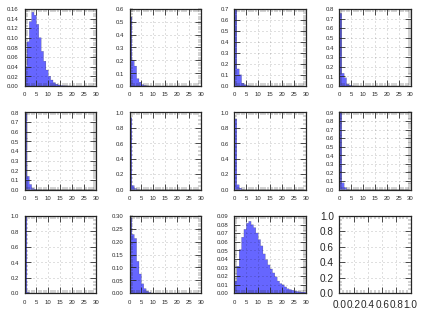

In [3]:
# All sectors (incl. neighbors)

fig, axs = plt.subplots(3, 4, figsize=(6.,6.*3/4), tight_layout=True)

stats = []

def draw(x):
  ax = axs[i/4,i%4]
  w = np.ones_like(x)/float(len(x))
  hist, edges, _ = ax.hist(x, bins=30, range=(0.,30.), weights=w, histtype='stepfilled', alpha=0.6)
  #ax.set_xlabel('# of LCTs per event')
  #ax.set_ylabel('a.u.')
  ax.tick_params(axis='both', which='major', labelsize=6)

# Loop over detector types
for i in xrange(11):
  if i == 0:    # ME1/1
    counts_tmp_0 = counts[:,:,:,0:0+3]
    counts_tmp_1 = counts[:,:,:,9:9+3]
    counts_tmp_2 = counts[:,:,:,[9+3-1]]  # neighbor
    counts_tmp = np.concatenate((counts_tmp_0, counts_tmp_1, counts_tmp_2), axis=-1)
  elif i == 1:  # ME2/1
    counts_tmp_0 = counts[:,:,:,18:18+3]
    counts_tmp_1 = counts[:,:,:,[18+3-1]]  # neighbor
    counts_tmp = np.concatenate((counts_tmp_0, counts_tmp_1), axis=-1)
  elif i == 2:  # ME3/1
    counts_tmp_0 = counts[:,:,:,27:27+3]
    counts_tmp_1 = counts[:,:,:,[27+3-1]]  # neighbor
    counts_tmp = np.concatenate((counts_tmp_0, counts_tmp_1), axis=-1)
  elif i == 3:  # ME4/1
    counts_tmp_0 = counts[:,:,:,36:36+3]
    counts_tmp_1 = counts[:,:,:,[36+3-1]]  # neighbor
    counts_tmp = np.concatenate((counts_tmp_0, counts_tmp_1), axis=-1)
  elif i == 4:  # ME1/2
    counts_tmp_0 = counts[:,:,:,0+3:0+3+3]
    counts_tmp_1 = counts[:,:,:,9+3:9+3+3]
    counts_tmp_2 = counts[:,:,:,[9+3+3-1]]  # neighbor
    counts_tmp = np.concatenate((counts_tmp_0, counts_tmp_1, counts_tmp_2), axis=-1)
  elif i == 5:  # ME2/2
    counts_tmp_0 = counts[:,:,:,18+3:18+3+6]
    counts_tmp_1 = counts[:,:,:,[18+3+6-1]]  # neighbor
    counts_tmp = np.concatenate((counts_tmp_0, counts_tmp_1), axis=-1)
  elif i == 6:  # ME3/2
    counts_tmp_0 = counts[:,:,:,27+3:27+3+6]
    counts_tmp_1 = counts[:,:,:,[27+3+6-1]]  # neighbor
    counts_tmp = np.concatenate((counts_tmp_0, counts_tmp_1), axis=-1)
  elif i == 7:  # ME4/2
    counts_tmp_0 = counts[:,:,:,36+3:36+3+6]
    counts_tmp_1 = counts[:,:,:,[36+3+6-1]]  # neighbor
    counts_tmp = np.concatenate((counts_tmp_0, counts_tmp_1), axis=-1)
  elif i == 8:  # ME1/3
    counts_tmp_0 = counts[:,:,:,0+3+3:0+3+3+3]
    counts_tmp_1 = counts[:,:,:,9+3+3:9+3+3+3]
    counts_tmp_2 = counts[:,:,:,[9+3+3+3-1]]  # neighbor
    counts_tmp = np.concatenate((counts_tmp_0, counts_tmp_1, counts_tmp_2), axis=-1)
  elif i == 9:  # ME0
    counts_tmp_0 = counts[:,:,:,45:45+3]
    counts_tmp_1 = counts[:,:,:,[45+3-1]]  # neighbor
    counts_tmp = np.concatenate((counts_tmp_0, counts_tmp_1), axis=-1)
  elif i == 10: # TOTAL
    counts_tmp_0 = counts[:,:,:,:]
    counts_tmp_1 = counts[:,:,:,[9+3-1, 18+3-1, 27+3-1, 36+3-1, 9+3+3-1, 18+3+6-1, 27+3+6-1, 36+3+6-1, 9+3+3+3-1, 45+3-1]]  # neighbor
    counts_tmp = np.concatenate((counts_tmp_0, counts_tmp_1), axis=-1)
    assert(counts_tmp.shape[-1] == 48+10)
  else:
    raise Exception('FAIL')
    
  # Max 2 LCTs per chamber
  if i <= 8:
    counts_tmp = np.clip(counts_tmp, 0, 2)
  elif i == 9:  # ME0
    counts_tmp = np.clip(counts_tmp, 0, 2)
  elif i == 10:
    counts_tmp[:,:,:,0:45] = np.clip(counts_tmp[:,:,:,0:45], 0, 2)
    counts_tmp[:,:,:,45:45+3] = np.clip(counts_tmp[:,:,:,45:45+3], 0, 2)  # ME0
    counts_tmp[:,:,:,45+3:45+3+9] = np.clip(counts_tmp[:,:,:,45+3:45+3+9], 0, 2)
    counts_tmp[:,:,:,45+3+9:45+3+9+1] = np.clip(counts_tmp[:,:,:,45+3+9:45+3+9+1], 0, 2)  # ME0
  else:
    raise Exception('FAIL')
  
  # Count
  old_shape = counts_tmp.shape
  counts_tmp = counts_tmp.reshape(len(jobs)*nevents_per_job, -1)
  counts_tmp = counts_tmp.sum(axis=1)
  
  stats.append(np.mean(counts_tmp))
  print old_shape, counts_tmp.shape, np.mean(counts_tmp), np.std(counts_tmp), np.percentile(counts_tmp, [95., 98., 99.], overwrite_input=True)
  
  # Draw
  draw(counts_tmp)


# End loop over detector types
plt.show()

In [4]:
names = ["ME1/1", "ME2/1", "ME3/1", "ME4/1", "ME1/2", "ME2/2", "ME3/2", "ME4/2", "ME1/3", "ME0", "TOTAL"]

assert(len(names) == len(stats))

# Print Markdown, render later with markdown-here.com
print "chmb type | avg occupancy"
print ":--|:--"
for x in zip(names, stats):
  print "{0} | {1:.3f}".format(x[0], x[1])

chmb type | avg occupancy
:--|:--
ME1/1 | 4.418
ME2/1 | 0.908
ME3/1 | 0.517
ME4/1 | 0.404
ME1/2 | 0.312
ME2/2 | 0.089
ME3/2 | 0.108
ME4/2 | 0.138
ME1/3 | 0.015
ME0 | 1.708
TOTAL | 8.617


chmb type | avg occupancy
:--|:--
ME1/1 | 4.418
ME2/1 | 0.908
ME3/1 | 0.517
ME4/1 | 0.404
ME1/2 | 0.312
ME2/2 | 0.089
ME3/2 | 0.108
ME4/2 | 0.138
ME1/3 | 0.015
ME0 | 1.708
TOTAL | 8.617

(6, 8000, 12, 6) (48000,) 3.81 2.277412640110117 [ 8.  9. 10.]
(6, 8000, 12, 3) (48000,) 0.6817083333333334 0.8976258026578905 [2. 3. 4.]
(6, 8000, 12, 3) (48000,) 0.38695833333333335 0.669493526180218 [2. 2. 3.]
(6, 8000, 12, 3) (48000,) 0.3028958333333333 0.5870334580038622 [1. 2. 2.]
(6, 8000, 12, 6) (48000,) 0.2697291666666667 0.5908471403975585 [1. 2. 2.]
(6, 8000, 12, 6) (48000,) 0.07635416666666667 0.29315674061152375 [1. 1. 1.]
(6, 8000, 12, 6) (48000,) 0.09177083333333333 0.31704197537440615 [1. 1. 1.]
(6, 8000, 12, 6) (48000,) 0.11772916666666666 0.3591573610308424 [1. 1. 2.]
(6, 8000, 12, 6) (48000,) 0.01325 0.11704459620161879 [0. 0. 1.]
(6, 8000, 12, 3) (48000,) 1.2779375 1.1744239351388763 [3. 4. 5.]
(6, 8000, 12, 48) (48000,) 7.028333333333333 4.1445382399276065 [15. 17. 19.]


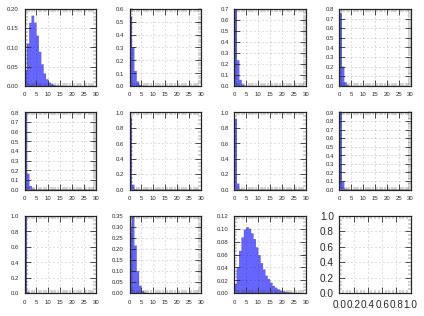

In [5]:
# All sectors (excl. neighbors)

fig, axs = plt.subplots(3, 4, figsize=(6.,6.*3/4), tight_layout=True)

stats = []

def draw(x):
  ax = axs[i/4,i%4]
  w = np.ones_like(x)/float(len(x))
  hist, edges, _ = ax.hist(x, bins=30, range=(0.,30.), weights=w, histtype='stepfilled', alpha=0.6)
  #ax.set_xlabel('# of LCTs per event')
  #ax.set_ylabel('a.u.')
  ax.tick_params(axis='both', which='major', labelsize=6)

# Loop over detector types
for i in xrange(11):
  if i == 0:    # ME1/1
    counts_tmp_0 = counts[:,:,:,0:0+3]
    counts_tmp_1 = counts[:,:,:,9:9+3]
    counts_tmp = np.concatenate((counts_tmp_0, counts_tmp_1), axis=-1)
  elif i == 1:  # ME2/1
    counts_tmp = counts[:,:,:,18:18+3]
  elif i == 2:  # ME3/1
    counts_tmp = counts[:,:,:,27:27+3]
  elif i == 3:  # ME4/1
    counts_tmp = counts[:,:,:,36:36+3]
  elif i == 4:  # ME1/2
    counts_tmp_0 = counts[:,:,:,0+3:0+3+3]
    counts_tmp_1 = counts[:,:,:,9+3:9+3+3]
    counts_tmp = np.concatenate((counts_tmp_0, counts_tmp_1), axis=-1)
  elif i == 5:  # ME2/2
    counts_tmp = counts[:,:,:,18+3:18+3+6]
  elif i == 6:  # ME3/2
    counts_tmp = counts[:,:,:,27+3:27+3+6]
  elif i == 7:  # ME4/2
    counts_tmp = counts[:,:,:,36+3:36+3+6]
  elif i == 8:  # ME1/3
    counts_tmp_0 = counts[:,:,:,0+3+3:0+3+3+3]
    counts_tmp_1 = counts[:,:,:,9+3+3:9+3+3+3]
    counts_tmp = np.concatenate((counts_tmp_0, counts_tmp_1), axis=-1)
  elif i == 9:  # ME0
    counts_tmp = counts[:,:,:,45:45+3]
  elif i == 10: # TOTAL
    counts_tmp = counts[:,:,:,:]
    assert(counts_tmp.shape[-1] == 48)
  else:
    raise Exception('FAIL')
    
  # Max 2 LCTs per chamber
  if i <= 8:
    counts_tmp = np.clip(counts_tmp, 0, 2)
  elif i == 9:  # ME0
    counts_tmp = np.clip(counts_tmp, 0, 2)
  elif i == 10:
    counts_tmp[:,:,:,0:45] = np.clip(counts_tmp[:,:,:,0:45], 0, 2)
    counts_tmp[:,:,:,45:45+3] = np.clip(counts_tmp[:,:,:,45:45+3], 0, 2)  # ME0
  else:
    raise Exception('FAIL')
  
  # Count
  old_shape = counts_tmp.shape
  counts_tmp = counts_tmp.reshape(len(jobs)*nevents_per_job, -1)
  counts_tmp = counts_tmp.sum(axis=1)
  
  stats.append(np.mean(counts_tmp))
  print old_shape, counts_tmp.shape, np.mean(counts_tmp), np.std(counts_tmp), np.percentile(counts_tmp, [95., 98., 99.], overwrite_input=True)
  
  # Draw
  draw(counts_tmp)


# End loop over detector types
plt.show()

In [6]:
names = ["ME1/1", "ME2/1", "ME3/1", "ME4/1", "ME1/2", "ME2/2", "ME3/2", "ME4/2", "ME1/3", "ME0", "TOTAL"]

assert(len(names) == len(stats))

# Print Markdown, render later with markdown-here.com
print "chmb type | avg occupancy"
print ":--|:--"
for x in zip(names, stats):
  print "{0} | {1:.3f}".format(x[0], x[1])

chmb type | avg occupancy
:--|:--
ME1/1 | 3.810
ME2/1 | 0.682
ME3/1 | 0.387
ME4/1 | 0.303
ME1/2 | 0.270
ME2/2 | 0.076
ME3/2 | 0.092
ME4/2 | 0.118
ME1/3 | 0.013
ME0 | 1.278
TOTAL | 7.028


chmb type | avg occupancy
:--|:--
ME1/1 | 3.810
ME2/1 | 0.682
ME3/1 | 0.387
ME4/1 | 0.303
ME1/2 | 0.270
ME2/2 | 0.076
ME3/2 | 0.092
ME4/2 | 0.118
ME1/3 | 0.013
ME0 | 1.278
TOTAL | 7.028

0.3581875 0.6050943850704202 [2. 2. 2.]
0.09539583333333333 0.3100464507929506 [1. 1. 1.]
0.019145833333333334 0.1385494029794868 [0. 0. 1.]
0.0015833333333333333 0.040280181920586654 [0. 0. 0.]


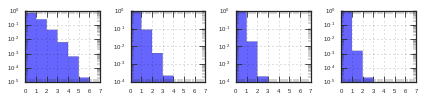

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(6.,6.*1/4), tight_layout=True)

stats1 = []
stats2 = []

def draw(x):
  ax = axs[i]
  w = np.ones_like(x)/float(len(x))
  hist, edges, _ = ax.hist(x, bins=7, range=(0.,7.), weights=w, histtype='stepfilled', alpha=0.6)
  #ax.set_xlabel('# of muons per event')
  #ax.set_ylabel('a.u.')
  ax.tick_params(axis='both', which='major', labelsize=6)
  ax.set_yscale('log')

# Loop over pt threshold
for i in xrange(4):
  counts_tmp = counts_part[:,:,i]
  
  counts_tmp = counts_tmp.reshape(-1)
  #print i, counts_tmp.shape
  
  draw(counts_tmp)
  
  stats1.append(np.mean(counts_tmp))
  stats2.append(np.percentile(counts_tmp, [95., 98., 99.], overwrite_input=True))
  print np.mean(counts_tmp), np.std(counts_tmp), np.percentile(counts_tmp, [95., 98., 99.], overwrite_input=True)


In [8]:
names = [">2 GeV", ">3 GeV", ">5 GeV", ">10 GeV"]

assert(len(names) == len(stats1))
assert(len(names) == len(stats2))

# Print Markdown, render later with markdown-here.com
print "pt | avg | 95% | 98% | 99%"
print ":--|:--|:--|:--|:--"
for x in zip(names, stats1, stats2):
  print "{0} | {1:.3f} | {2:.1f} | {3:.1f} | {4:.1f}".format(x[0], x[1], x[2][0], x[2][1], x[2][2])

pt | avg | 95% | 98% | 99%
:--|:--|:--|:--|:--
>2 GeV | 0.358 | 2.0 | 2.0 | 2.0
>3 GeV | 0.095 | 1.0 | 1.0 | 1.0
>5 GeV | 0.019 | 0.0 | 0.0 | 1.0
>10 GeV | 0.002 | 0.0 | 0.0 | 0.0


pt | avg | 95% | 98% | 99%
:--|:--|:--|:--|:--
>2 GeV | 0.358 | 2.0 | 2.0 | 2.0
>3 GeV | 0.095 | 1.0 | 1.0 | 1.0
>5 GeV | 0.019 | 0.0 | 0.0 | 1.0
>10 GeV | 0.002 | 0.0 | 0.0 | 0.0

In [9]:
stats = [276,122,67,54,12,5,7,16,1,561]
stats = map(lambda x: x/750., stats)  # divide by total L1 rate
stats = map(lambda x: x/5.53, stats)  # divide by magic number 5.52

mults = [6,3,3,3,6,6,6,6,6,6]
mults = map(lambda x: x*12, mults)  # multiply by 12 sectors

names = ["ME1/1", "ME2/1", "ME3/1", "ME4/1", "ME1/2", "ME2/2", "ME3/2", "ME4/2", "ME1/3", "TOTAL"]

assert(len(names) == len(stats))

# Print Markdown, render later with markdown-here.com
print "chmb type | avg occupancy"
print ":--|:--"
for x in zip(names, stats, mults):
  print "{0} | {1:.3f}".format(x[0], x[1] * x[2])

chmb type | avg occupancy
:--|:--
ME1/1 | 4.791
ME2/1 | 1.059
ME3/1 | 0.582
ME4/1 | 0.469
ME1/2 | 0.208
ME2/2 | 0.087
ME3/2 | 0.122
ME4/2 | 0.278
ME1/3 | 0.017
TOTAL | 9.739
